# I. Train and test datasets

In [1]:
# Hyperparameters for dataset

D = 784 #dimension
k = 3 # num of 2d planes in dim D
n = 6*(10**3) # num of points in each plane
#n = 10**3 # num of points in each plane

batch_size  = 16
split_ratio = 0.2
shift_class = 0

# Set manual seed for reproducibility
# torch.manual_seed(0)

In [2]:
import torch
import torchvision

phi = [] #list of k ontonormal bases in k planes
for j in range(k):
    # creating random planes
    rand_vectors = torch.rand(D, 2)
    q, r = torch.qr(rand_vectors)
    phi.append(q)
#phi

#creating samples from normal distributions via torch distributions
data = []
for i in range(k):
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2) + shift_class*(i+1), torch.eye(2))
    #m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
    samples = m.sample(sample_shape=(n,)).T
    #samples = normalize(samples, p = 1, dim = 0)
    #data.append(normalize(torch.matmul(phi[i], samples)))
    data.append(torch.matmul(phi[i], samples))
data_tensor = torch.cat(data, dim=1)

data_tensor = data_tensor.T
data_tensor = data_tensor.reshape(k*n, 1, 28, 28)

labels_list = []
for i in range(k):
    labels_list.append(i*(torch.ones(n)))
labels = torch.cat(labels_list)

train_dataset = torch.utils.data.TensorDataset(data_tensor,labels)

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


train_dataset.transform = train_transform

m=len(train_dataset)

train_data, test_data = torch.utils.data.random_split(train_dataset, [int(m-m*split_ratio), int(m*split_ratio)])

test_loader  = torch.utils.data.DataLoader(test_data , batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# test_data[:][0] will give the vectors of data without labels from the test part of the dataset

/tmp/ipykernel_109999/983047828.py:8: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  q, r = torch.qr(rand_vectors)


# II. Fit dimension reduction models

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## II.1. TSNE check

In [4]:
# TNSE check on test set
synthetic_points = test_data[:][0].view(-1,28*28)

tsne   = TSNE(n_components=2, verbose=1, random_state=123)
z_test = tsne.fit_transform(synthetic_points.numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3600 samples in 0.001s...
[t-SNE] Computed neighbors for 3600 samples in 0.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3600
[t-SNE] Computed conditional probabilities for sample 2000 / 3600
[t-SNE] Computed conditional probabilities for sample 3000 / 3600
[t-SNE] Computed conditional probabilities for sample 3600 / 3600
[t-SNE] Mean sigma: 0.179661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.356354
[t-SNE] KL divergence after 1000 iterations: 0.647356


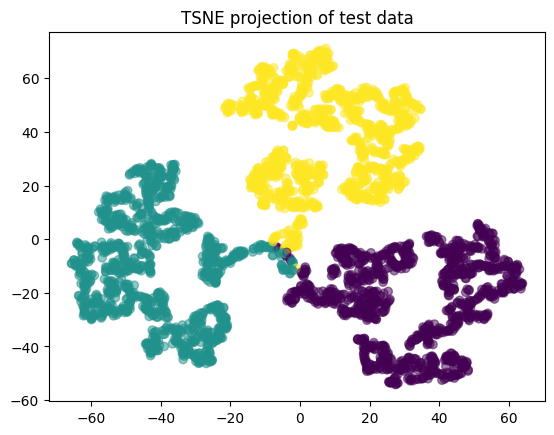

In [5]:
plt.scatter( z_test[:,0], z_test[:,1], c=test_data[:][1], alpha=0.5 )
plt.title( "TSNE projection of test data")
plt.show()

In [6]:
# TNSE check on train set
synthetic_points = train_data[:][0].view(-1,28*28)

tsne   = TSNE(n_components=2, verbose=1, random_state=123)
z_train = tsne.fit_transform(synthetic_points.numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14400 samples in 0.003s...
[t-SNE] Computed neighbors for 14400 samples in 1.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14400
[t-SNE] Computed conditional probabilities for sample 2000 / 14400
[t-SNE] Computed conditional probabilities for sample 3000 / 14400
[t-SNE] Computed conditional probabilities for sample 4000 / 14400
[t-SNE] Computed conditional probabilities for sample 5000 / 14400
[t-SNE] Computed conditional probabilities for sample 6000 / 14400
[t-SNE] Computed conditional probabilities for sample 7000 / 14400
[t-SNE] Computed conditional probabilities for sample 8000 / 14400
[t-SNE] Computed conditional probabilities for sample 9000 / 14400
[t-SNE] Computed conditional probabilities for sample 10000 / 14400
[t-SNE] Computed conditional probabilities for sample 11000 / 14400
[t-SNE] Computed conditional probabilities for sample 12000 / 14400
[t-SNE] Computed conditional probabilities for sam

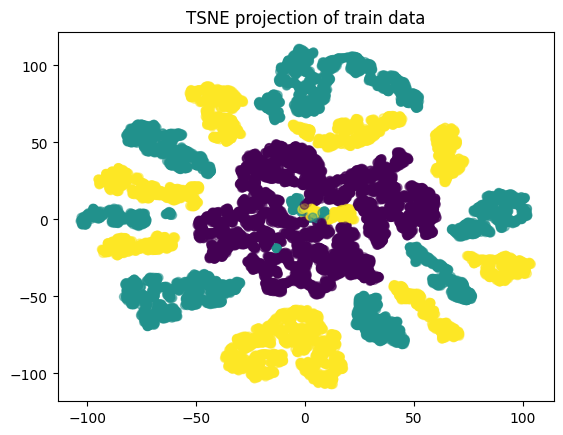

In [7]:
plt.scatter( z_train[:,0], z_train[:,1], c=train_data[:][1], alpha=0.5 )
plt.title( "TSNE projection of train data")
plt.show()

## II.2. Plots using Seaborn

In [8]:
import pandas as pd 

# Format data
df = pd.DataFrame()
#df["y"] = labels.numpy()
df["y"] = test_data[:][1].numpy() #test_data[:][1] are labels
df["comp-1"] = z_test[:,0]
df["comp-2"] = z_test[:,1]

/tmp/ipykernel_109999/1628473012.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Synthetic dataset data T-SNE projection')]

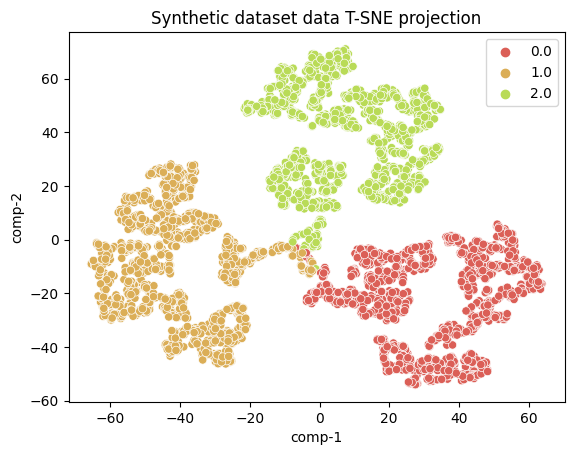

In [9]:
import seaborn as sns
import numpy as np # this module is useful to work with numerical arrays


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Synthetic dataset data T-SNE projection")